In [3]:
Patient = "P007" #"P015/P015_S01_D2024-07-06"
run = None




2025-05-03 19:45:25,447 - INFO - Using device: cpu


Intervall: 15000 - 17500


2025-05-03 19:45:26,160 - INFO - Loaded primary TDMS file: Data/P007/P007_S01_D2024-04-11.tdms
2025-05-03 19:45:26,531 - INFO - Loaded additional TDMS file: Data/P007/P007_S01_D2024-04-11_addCh.tdms
2025-05-03 19:45:26,532 - INFO - Loaded sensor log file: Data/P007/QZFM_log_file.txt
2025-05-03 19:45:26,532 - INFO - Available runs: Brust, Ruecken, Leermessung
2025-05-03 19:45:26,547 - INFO - Model loaded from MCG_segmentation/MCGSegmentator_s/checkpoints/best/model.pth


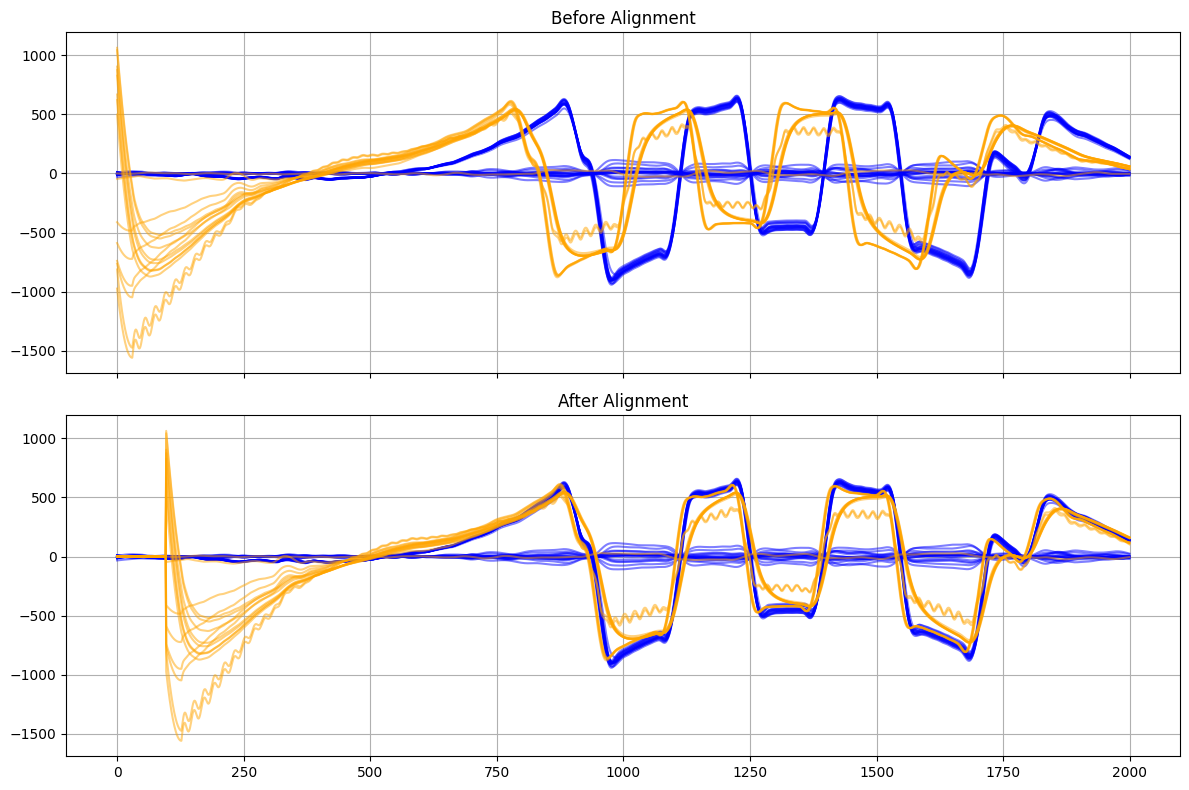

2025-05-03 19:45:28,435 - INFO - Resampling data from 1000Hz to 250Hz. Target length: 73148, Original length: 292592 samples.


(4, 4, 73148) (4, 4, 73148) (4, 4, 73148)


In [11]:
import importlib
import analyzer
importlib.reload(analyzer)

from analyzer import Analyzer
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import json



def load_patient_data(patient: str, run: str = None):
    """
    Load patient data from the specified file.
    """

    overview = pd.read_excel("Data/overview.xlsx")
    dir = "Data/" + patient + "/"
    number = re.findall(r'\d+', dir)
    patient_number = int(number[0]) if number else None


    if overview.loc[overview["Probanten Nr."] == patient_number, "runs"].values[0].strip() == "-":
        print(f"No runs found for patient {patient_number}. Skipping...")
        return
    
    add_filename, file_name = None, None
    
    for file in os.listdir(dir):
        if file.endswith(".tdms") and file.startswith(patient):
            if run and run not in file:
                continue
            if "addCh" in file:
                add_filename = os.path.join(dir, file)
            else:
                file_name = os.path.join(dir, file)
            
    
    log_file_path = os.path.join(dir, "QZFM_log_file.txt")
    sensor_channels_to_exclude = json.loads(overview.loc[overview["Probanten Nr."] == patient_number, "Sensors to exclude"].values[0])

    
    intervall = overview.loc[overview["Probanten Nr."] == patient_number, "Intervall"].values[0]
    intervall = intervall.split(":") if isinstance(intervall, str) else intervall
    intervall_start = int(intervall[0]) if isinstance(intervall, list) else None
    intervall_end = int(intervall[1]) if isinstance(intervall, list) else None
    print(f"Intervall: {intervall_start} - {intervall_end}")

    return Analyzer(
        filename=file_name,
        add_filename=add_filename,
        log_file_path=log_file_path,
        sensor_channels_to_exclude=sensor_channels_to_exclude
    ), intervall_start, intervall_end

analysis, intervall_start, intervall_end = load_patient_data(Patient, run)

for k in analysis.key_list:
    if k in ["Brustlage", "Brust", "Bauchlage", "Bauch"]:
        key = k
        break
    
(x_data, y_data, z_data), time, single_run = analysis.prepare_data(key, apply_default_filter=True, plot_alignment=True)

print(x_data.shape, y_data.shape, z_data.shape)




# Testing model segmentation

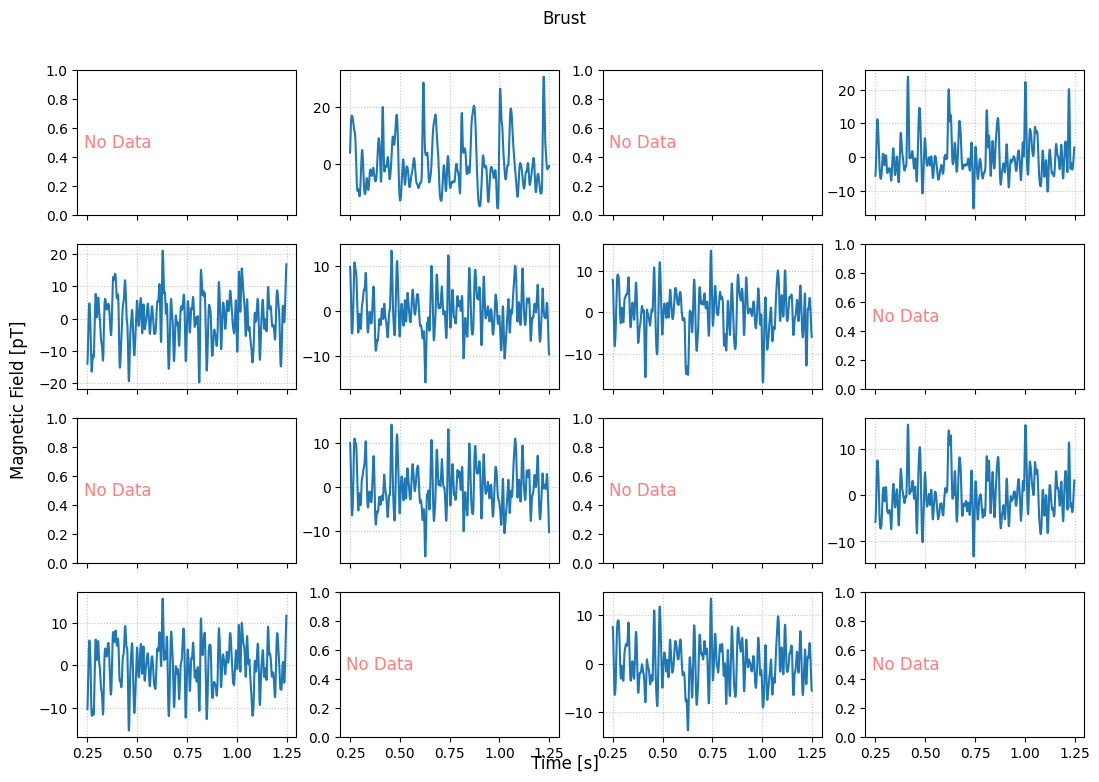

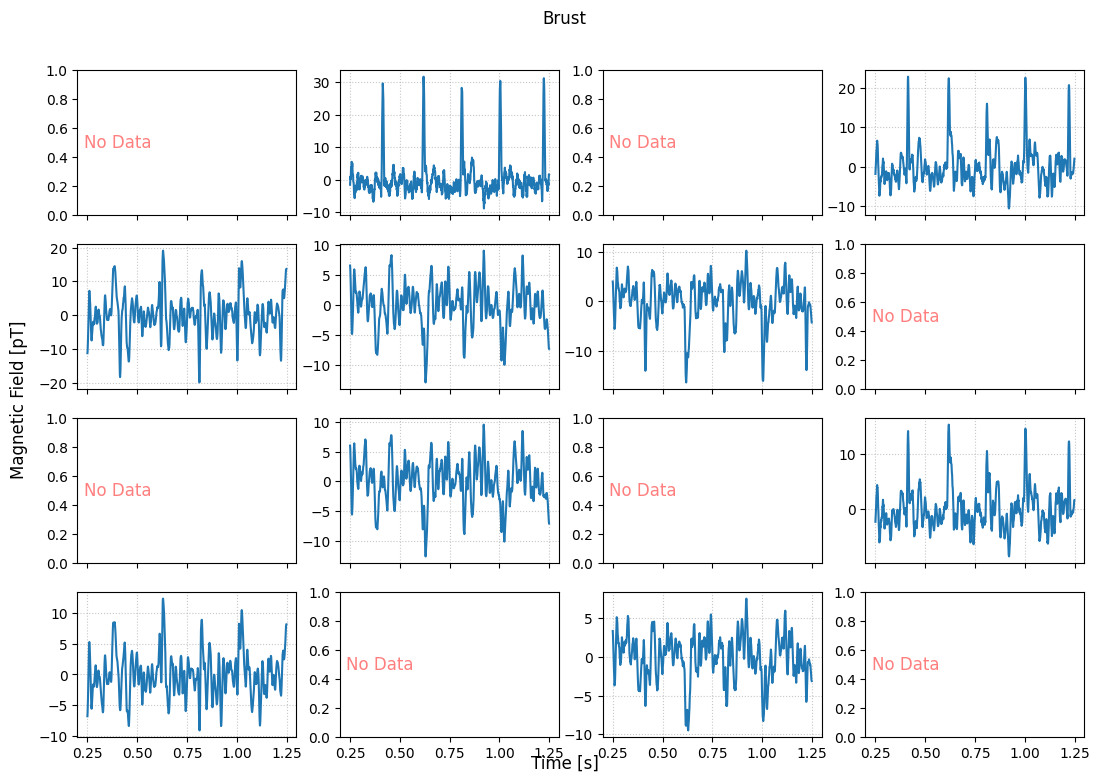

In [59]:

analysis.plot4x4(x_data[:, :, 250:1250], time[250:1250], name=key)
x_data, _, _ = analysis.ICA_filter(x_data, resample=False, heart_beat_score_threshold=0.8)

analysis.plot4x4(x_data[:, :, 250:1250], time[250:1250], name=key)

Improve Windowing

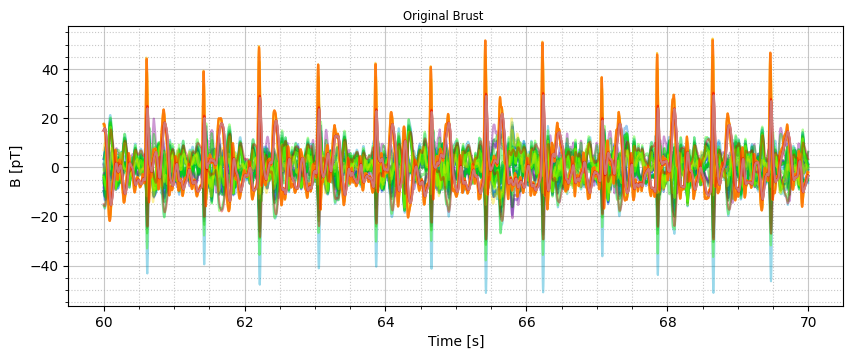

Heart Rate: 74.59 bpm
Heart Rate Variability (SDNN): 20.85 ms
Number of detected peaks: 12
Number of plausible RR intervals used: 11


ValueError: not enough values to unpack (expected 6, got 5)

In [ ]:

_data = single_run[:, intervall_start:intervall_end]



analysis.plotting_time_series(_data, time[intervall_start:intervall_end], 48, f"Original {key}")




# use cleanest channel for peak detection
peak_positions, ch, labels, _, _ = analysis.detect_qrs_complex_peaks_cleanest_channel(single_run[:, intervall_start:intervall_end], print_heart_rate=True, confidence_threshold=0.7)
if peak_positions is not None and len(peak_positions) > 0:
    plt.figure(figsize=(12, 4))
    plt.plot(_data[ch, :], label='Signal', linewidth=1.2)
    #plt.plot(resampled_data[ch, :], label='Signal', linewidth=1.2)
    plt.plot(peak_positions, _data[ch, peak_positions], "ro", markersize=6, label='R Peaks')
    plt.title(f"QRS Detection - Cleanest Channel {ch + 1}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No R peaks detected or `peak_positions` is empty.")
analysis.plot_segmented_signal(_data[ch, :], labels[ch, :])

# window averaging
avg_channels, time_window = analysis.avg_window(_data, peak_positions, window_left=0.3, window_right=0.5)
analysis.plotting_time_series(avg_channels, time_window, 48, f"Original {key}")



## Test Magnetic Moment fit

Starting robust dipole fitting...
Converting field data...
Smoothing field data...
Fitting dipole model...
Processing time chunk 0 to 50
  Fitted time 0/200
  Fitted time 10/200
  Fitted time 20/200
  Fitted time 30/200
  Fitted time 40/200
Processing time chunk 50 to 100
  Fitted time 50/200
  Fitted time 60/200
  Fitted time 70/200
  Fitted time 80/200
  Fitted time 90/200
Processing time chunk 100 to 150
  Fitted time 100/200
  Fitted time 110/200
  Fitted time 120/200
  Fitted time 130/200
  Fitted time 140/200
Processing time chunk 150 to 200
  Fitted time 150/200
  Fitted time 160/200
  Fitted time 170/200
  Fitted time 180/200
  Fitted time 190/200
Predicting sensor signals...
Visualizing results...


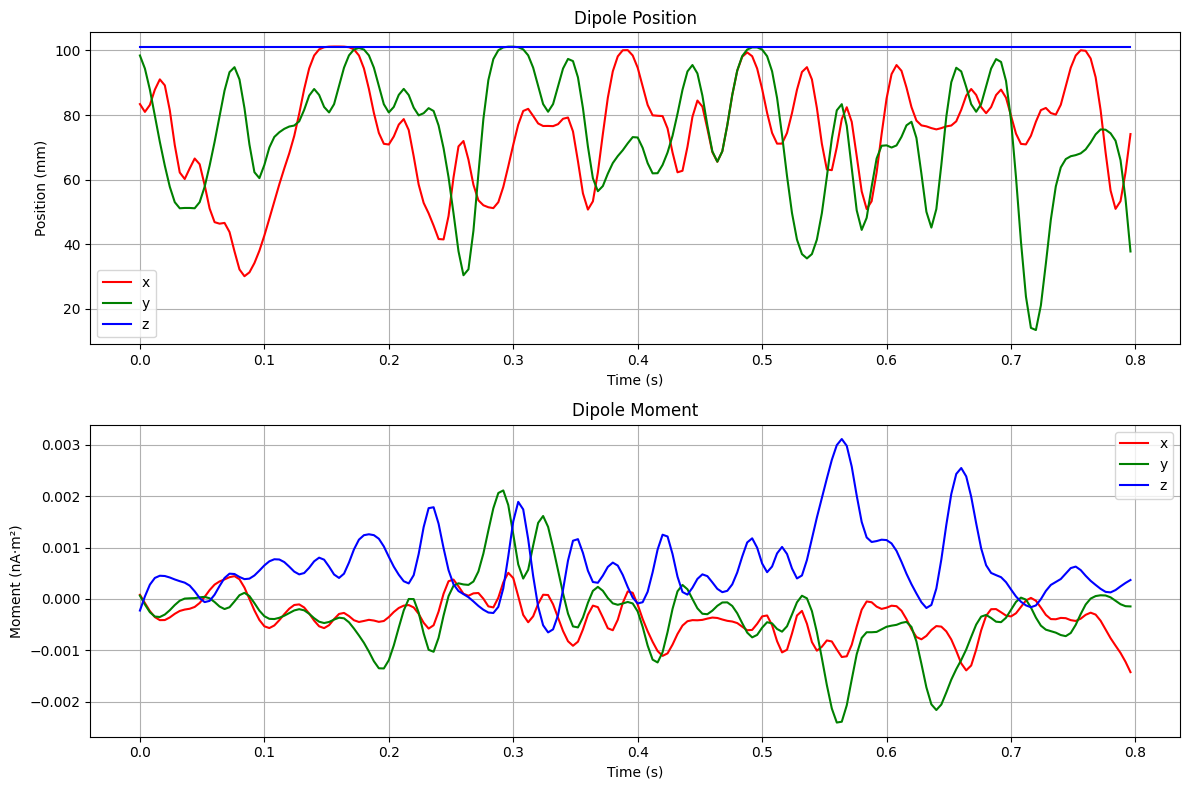

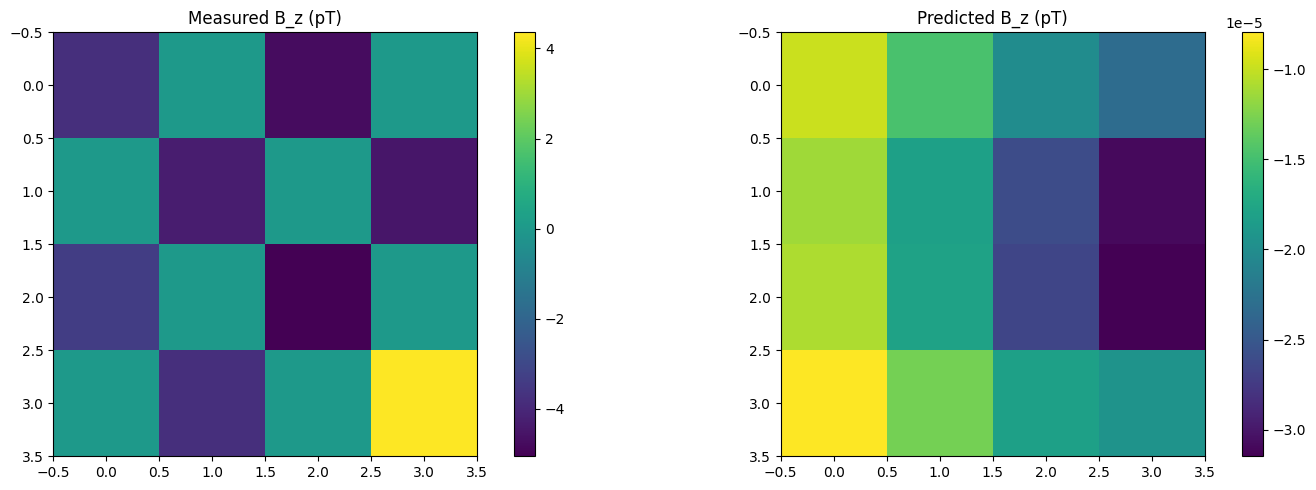

In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def gaussian_smoothing(x, sigma=2):
    """Gaussian smoothing along time axis."""
    x_smooth = gaussian_filter1d(x, sigma=sigma, axis=-1, mode='nearest')
    return x_smooth

# --- Constants and grid ---
grid_spacing = 25.3e-3  # 25.3 mm
MU_0 = 4 * np.pi * 1e-7  # T·m/A

def dipole_field_torch(r_sensor, r0, m):
    """Numerically stable magnetic dipole field calculation."""
    try:
        r_prime = r_sensor - r0
    except Exception as e:
        r_prime = torch.from_numpy(r_sensor) - r0
    
    # Robust norm calculation with a stabilizing epsilon
    epsilon = 1e-10
    r_prime_squared = torch.sum(r_prime**2, dim=-1, keepdim=True)
    r_norm = torch.sqrt(r_prime_squared + epsilon)
    
    # Safe division for unit vectors
    r_hat = r_prime / (r_norm + epsilon)
    
    # Dot product for projection
    m_dot_r_hat = torch.sum(m * r_hat, dim=-1, keepdim=True)
    
    # Calculate field with stable r_norm^3
    r_norm_cubed = r_norm**3 + epsilon
    B = (MU_0 / (4 * np.pi)) * ((3 * r_hat * m_dot_r_hat - m) / r_norm_cubed)
    
    return B

def fit_dipole_single_time(sensor_positions, B_meas_t, max_attempts=3):
    """Fit dipole with multiple attempts and robust error handling."""
    # Reshape to flat arrays
    sensors_flat = sensor_positions.reshape(-1, 3)
    B_meas_flat = torch.tensor(B_meas_t.reshape(-1, 3), dtype=torch.float32)
    
    # Filter out sensors with no signal
    valid = torch.norm(B_meas_flat, dim=-1) > 0
    if torch.sum(valid) < 3:  # Need at least 3 points for a meaningful fit
        print("Warning: Not enough valid sensors at this timestep.")
        return np.zeros(3), np.zeros(3)
    
    sensors_valid = sensors_flat[valid]
    B_meas_valid = B_meas_flat[valid]
    
    # Scale the measurements for numerical stability
    B_scale = torch.max(torch.norm(B_meas_valid, dim=-1)).item()
    if B_scale < 1e-15:
        B_scale = 1.0
    B_meas_valid = B_meas_valid / B_scale
    
    best_loss = float('inf')
    best_r0 = np.zeros(3)
    best_m = np.zeros(3)
    
    # Try multiple initializations
    for attempt in range(max_attempts):
        try:
            # Different initialization strategies for each attempt
            if attempt == 0:
                # Center of grid, moderate depth
                r0 = torch.tensor([2*grid_spacing, 2*grid_spacing, 2*grid_spacing], 
                                 dtype=torch.float32, requires_grad=True)
                # Moderate initial moment
                m = torch.tensor([1.0, 1.0, 1.0], dtype=torch.float32, requires_grad=True)
            elif attempt == 1:
                # Random position within grid
                r0 = torch.tensor([
                    torch.rand(1).item() * 4 * grid_spacing,
                    torch.rand(1).item() * 4 * grid_spacing,
                    torch.rand(1).item() * 4 * grid_spacing
                ], dtype=torch.float32, requires_grad=True)
                
                # Random moment orientation
                m_dir = torch.randn(3)
                m_dir = m_dir / torch.norm(m_dir)
                m = m_dir * 1.0  # Unit moment
                m.requires_grad = True
            else:
                # Different depth
                r0 = torch.tensor([2*grid_spacing, 2*grid_spacing, 4*grid_spacing], 
                                 dtype=torch.float32, requires_grad=True)
                # Different initial moment
                m = torch.tensor([0.0, 0.0, 1.0], dtype=torch.float32, requires_grad=True)
            
            # Use Adam optimizer with careful learning rate
            optimizer = torch.optim.Adam([r0, m], lr=0.01)
            
            # Define learning rate scheduler
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
            
            # Optimization loop
            loss_history = []
            patience = 20
            patience_counter = 0
            best_attempt_loss = float('inf')
            
            for step in range(500):
                optimizer.zero_grad()
                
                # Predict magnetic field
                B_pred = dipole_field_torch(sensors_valid, r0, m) / B_scale
                
                # Calculate loss with gradient clipping to avoid NaN
                loss = torch.mean((B_pred - B_meas_valid)**2)
                
                # Numerical check - if we hit NaN, break and try different initialization
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"NaN/Inf loss at step {step}. Trying different initialization.")
                    break
                
                loss.backward()
                
                # Clip gradients to prevent instability
                torch.nn.utils.clip_grad_norm_([r0, m], 1.0)
                
                optimizer.step()
                scheduler.step()
                
                # Constrain r0 to stay within grid
                with torch.no_grad():
                    r0.data = torch.clamp(r0.data, 0.0, 4*grid_spacing)
                
                loss_val = loss.item()
                loss_history.append(loss_val)
                
                # Update best solution for this attempt
                if loss_val < best_attempt_loss:
                    best_attempt_loss = loss_val
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                # Early stopping
                if patience_counter >= patience:
                    break
            
            # Check if this attempt gave a better result
            if best_attempt_loss < best_loss and not (torch.isnan(r0).any() or torch.isnan(m).any()):
                best_loss = best_attempt_loss
                best_r0 = r0.detach().numpy()
                best_m = (m * B_scale).detach().numpy()  # Rescale moment back
                
        except RuntimeError as e:
            print(f"Optimization error in attempt {attempt}: {e}")
            continue
    
    return best_r0, best_m

def fit_dipole_over_time(sensor_positions, B_meas, window_size=3):
    """Fit dipole with temporal windowing for stability."""
    T = B_meas.shape[-1]
    r0_all = np.zeros((T, 3))
    m_all = np.zeros((T, 3))
    
    # Process in smaller chunks
    chunk_size = 50  # Process 50 time points at once
    for chunk_start in range(0, T, chunk_size):
        chunk_end = min(chunk_start + chunk_size, T)
        print(f"Processing time chunk {chunk_start} to {chunk_end}")
        
        for t in range(chunk_start, chunk_end):
            # Use temporal window to improve stability
            window_start = max(0, t - window_size)
            window_end = min(T, t + window_size + 1)
            
            # Average field over small temporal window for stability
            B_meas_windowed = np.mean(B_meas[..., window_start:window_end], axis=-1)
            
            # Fit dipole
            r0, m = fit_dipole_single_time(sensor_positions, B_meas_windowed)
            
            r0_all[t] = r0
            m_all[t] = m
            
            if t % 10 == 0:
                print(f"  Fitted time {t}/{T}")
    
    # Post-process to smooth trajectories
    r0_smooth = gaussian_smoothing(r0_all.T, sigma=2).T
    m_smooth = gaussian_smoothing(m_all.T, sigma=2).T
    
    return r0_smooth, m_smooth

def predict_sensor_signal(sensor_positions, r0_all, m_all):
    """Predict magnetic field at sensor positions."""
    n_rows, n_cols, _ = sensor_positions.shape
    T = r0_all.shape[0]
    
    # Initialize output array
    B_pred = np.zeros((n_rows, n_cols, 3, T))
    
    # Process in batches to avoid memory issues
    batch_size = 100
    for t_start in range(0, T, batch_size):
        t_end = min(t_start + batch_size, T)
        
        for t in range(t_start, t_end):
            # Convert to torch tensors
            r0 = torch.tensor(r0_all[t], dtype=torch.float32)
            m = torch.tensor(m_all[t], dtype=torch.float32)
            
            # Process each sensor position
            for i in range(n_rows):
                for j in range(n_cols):
                    r_sensor = torch.tensor(sensor_positions[i, j], dtype=torch.float32).unsqueeze(0)
                    B = dipole_field_torch(r_sensor, r0, m)
                    B_pred[i, j, :, t] = B[0].detach().numpy()
    
    return B_pred

def visualize_dipole_fit(time_window, r0_all, m_all, B_meas, B_pred=None):
    """Basic visualization of dipole fit results."""
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Plot position
    plt.subplot(2, 1, 1)
    plt.plot(time_window, r0_all[:, 0] * 1000, 'r-', label='x')
    plt.plot(time_window, r0_all[:, 1] * 1000, 'g-', label='y')
    plt.plot(time_window, r0_all[:, 2] * 1000, 'b-', label='z')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (mm)')
    plt.title('Dipole Position')
    plt.legend()
    plt.grid(True)
    
    # Plot moment
    plt.subplot(2, 1, 2)
    plt.plot(time_window, m_all[:, 0] * 1e9, 'r-', label='x')
    plt.plot(time_window, m_all[:, 1] * 1e9, 'g-', label='y')
    plt.plot(time_window, m_all[:, 2] * 1e9, 'b-', label='z')
    plt.xlabel('Time (s)')
    plt.ylabel('Moment (nA·m²)')
    plt.title('Dipole Moment')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Plot field comparison for a specific time point if predicted field is available
    if B_pred is not None:
        mid_time = len(time_window) // 2
        
        plt.figure(figsize=(15, 5))
        
        # Plot measured field (Z component)
        plt.subplot(1, 2, 1)
        plt.imshow(B_meas[:, :, 2, mid_time] * 1e12, cmap='viridis')
        plt.title('Measured B_z (pT)')
        plt.colorbar()
        
        # Plot predicted field
        plt.subplot(1, 2, 2)
        plt.imshow(B_pred[:, :, 2, mid_time] * 1e12, cmap='viridis')
        plt.title('Predicted B_z (pT)')
        plt.colorbar()
        
        plt.tight_layout()
        plt.show()

def robust_dipole_fitting(x_data, y_data, z_data, time_window):
    """Main function to perform robust dipole fitting."""
    print("Starting robust dipole fitting...")
    
    # Prepare sensor grid
    x = np.arange(4) * grid_spacing
    y = np.arange(4) * grid_spacing
    X, Y = np.meshgrid(x, y)
    sensor_positions = np.stack([X, Y, np.zeros_like(X)], axis=-1)  # (4, 4, 3)
    
    # Prepare field data
    print("Converting field data...")
    Bx_meas = x_data * 1e-12  # Convert to Tesla
    By_meas = y_data * 1e-12
    Bz_meas = z_data * 1e-12
    
    # Check for missing or invalid data
    x_valid = np.any(np.isfinite(Bx_meas), axis=(0, 1))
    y_valid = np.any(np.isfinite(By_meas), axis=(0, 1))
    z_valid = np.any(np.isfinite(Bz_meas), axis=(0, 1))
    valid_times = x_valid & y_valid & z_valid
    
    if not np.all(valid_times):
        print(f"Warning: {np.sum(~valid_times)} time points have invalid data. Filling with zeros.")
        Bx_meas[..., ~valid_times] = 0.0
        By_meas[..., ~valid_times] = 0.0
        Bz_meas[..., ~valid_times] = 0.0
    
    # Assemble full field tensor
    B_meas = np.zeros((4, 4, 3, Bx_meas.shape[-1]))
    B_meas[..., 0, :] = Bx_meas
    B_meas[..., 1, :] = By_meas
    B_meas[..., 2, :] = Bz_meas
    
    # Apply gaussian smoothing to reduce noise
    print("Smoothing field data...")
    B_meas_smooth = gaussian_smoothing(B_meas, sigma=2)
    
    # Fit dipole model
    print("Fitting dipole model...")
    r0_all, m_all = fit_dipole_over_time(sensor_positions, B_meas_smooth)
    
    # Predict sensor signals
    print("Predicting sensor signals...")
    B_pred = predict_sensor_signal(sensor_positions, r0_all, m_all)
    
    # Visualize results
    print("Visualizing results...")
    visualize_dipole_fit(time_window, r0_all, m_all, B_meas, B_pred)
    
    return r0_all, m_all, B_pred

# Usage example
r0_all, m_all, B_pred = robust_dipole_fitting(x_data, y_data, z_data, time_window)

## Magentic Heart Vector

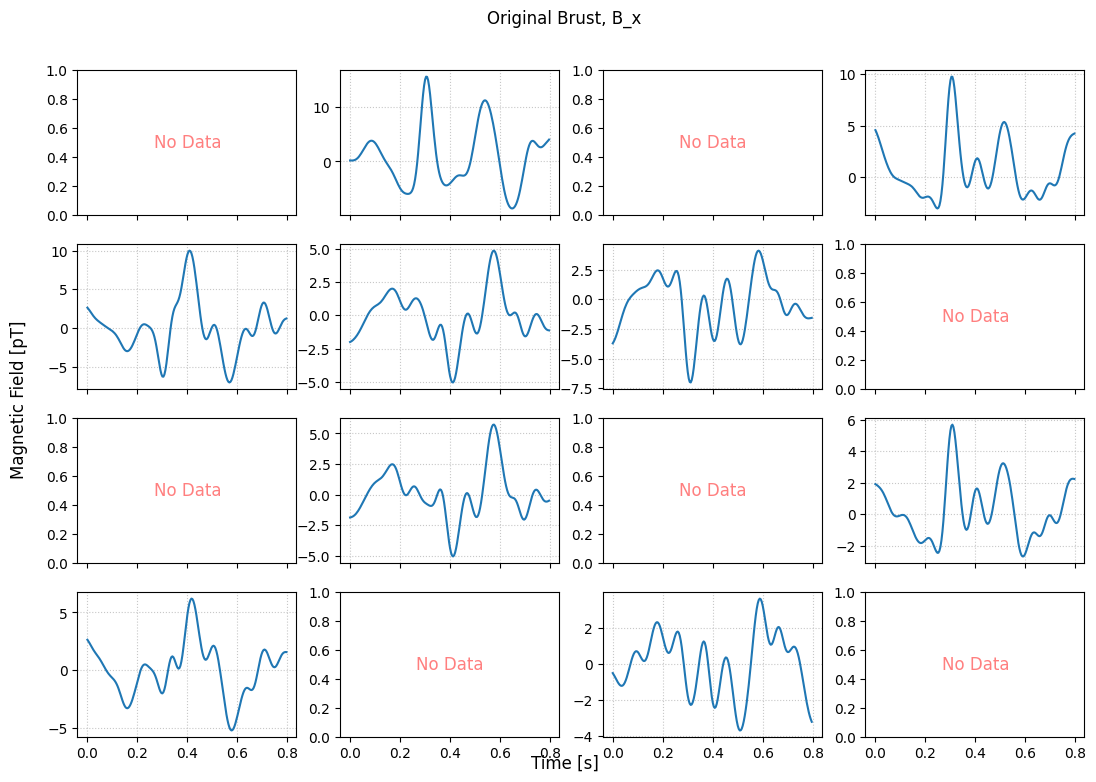

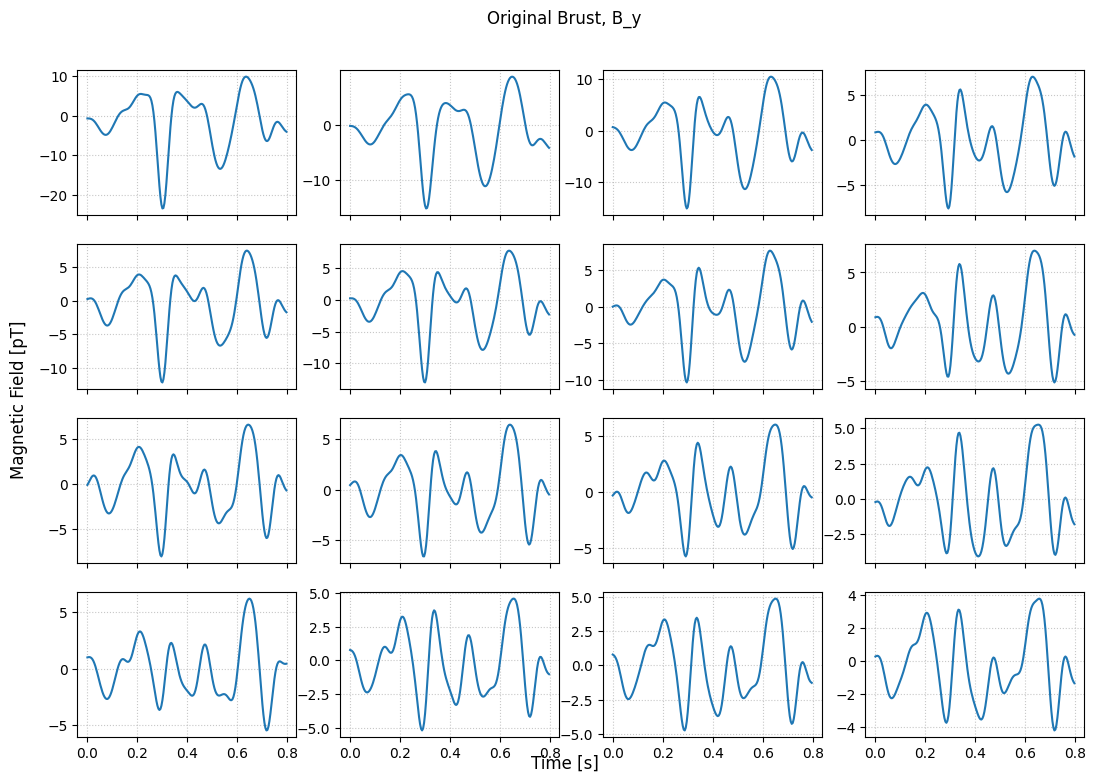

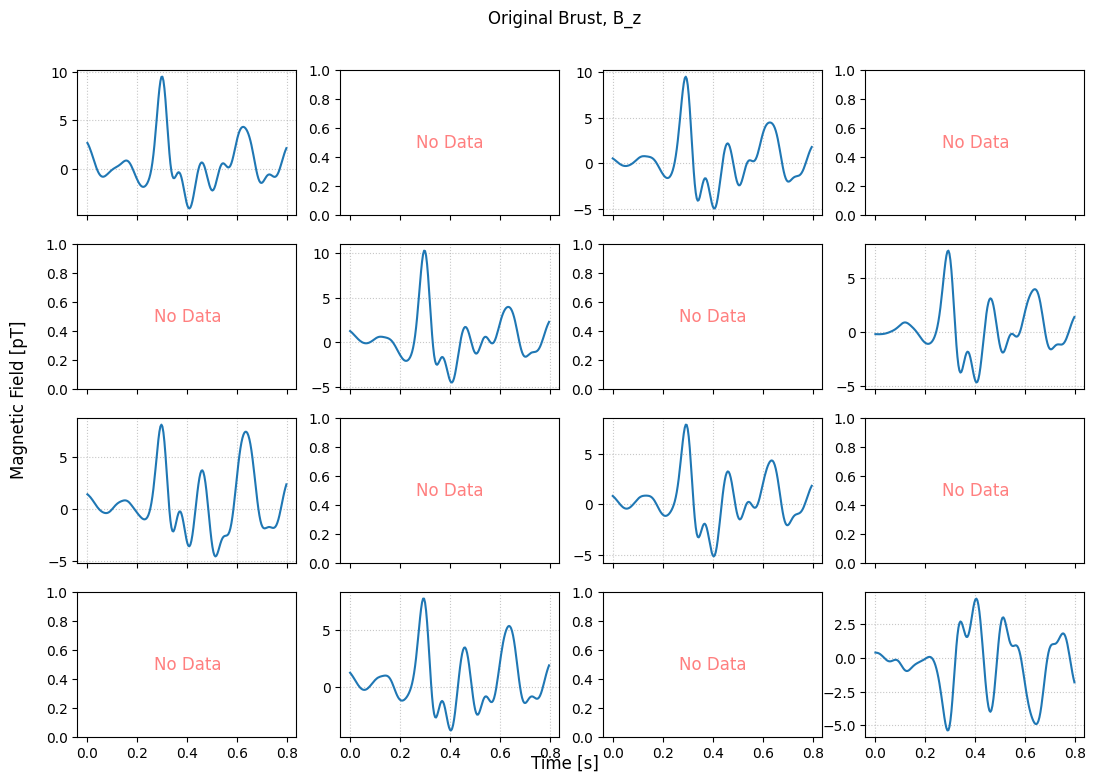

f1_data shape: (2, 200)

Channel Selection Results:
Channel   Mean Conf   P-Wave %    QRS %       T-Wave %    Plausibility   Final Score 
-------------------------------------------------------------------------------------
1         0.8271      9.00        16.00       43.00       0.4167         0.7083      
2         0.8227      29.00       24.50       22.50       0.2985         0.6466      

Best Channel Summary:
Channel   : 1
Mean Conf : 0.8271
Plausibility: 0.4167
Final Score: 0.7083
Segment Distribution:
  P-Wave % : 9.00%
  QRS %    : 16.00%
  T-Wave % : 43.00%


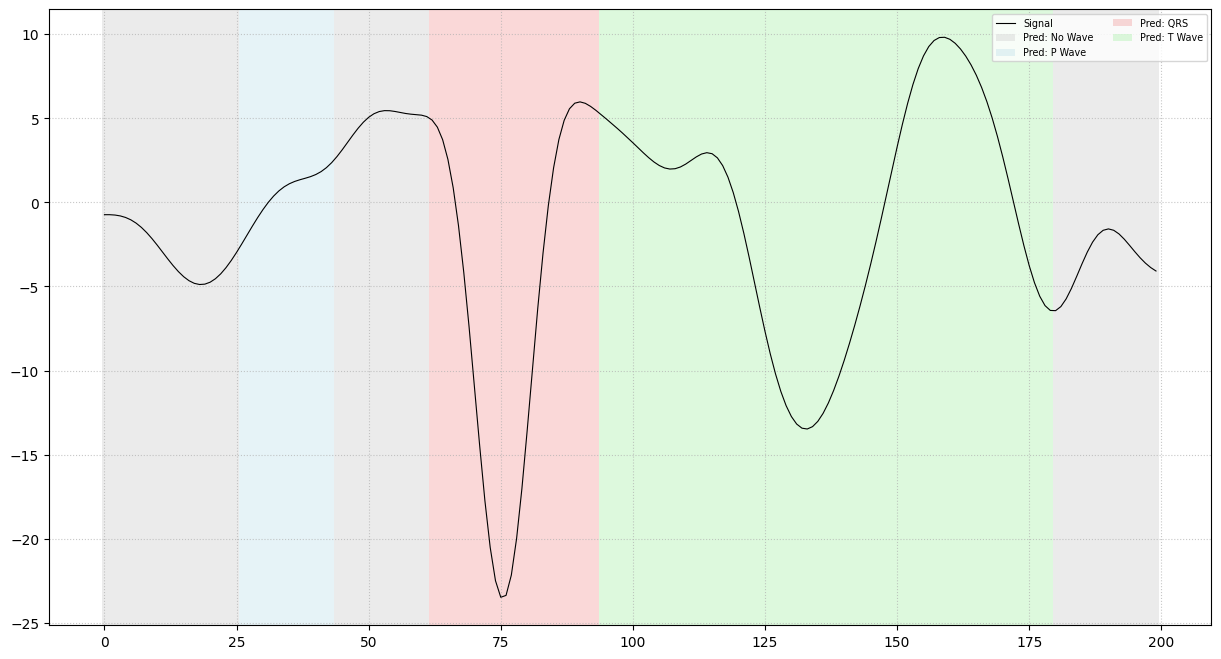

#######################################################################################
#######################################################################################


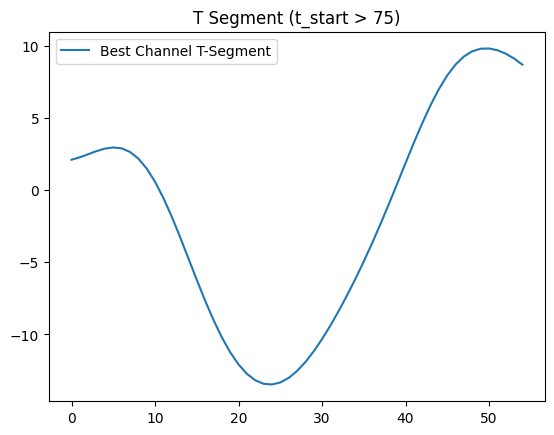

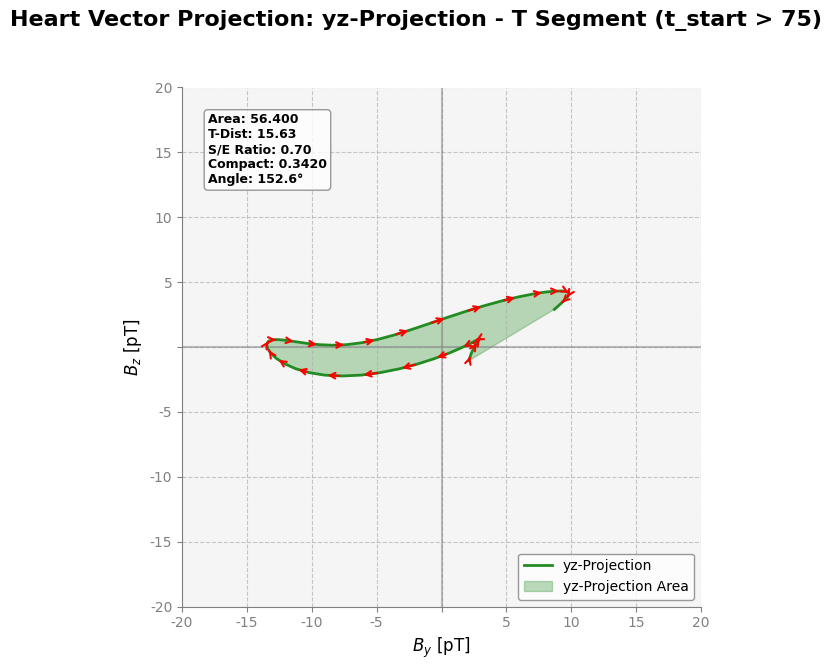

2025-05-03 12:57:23,846 - INFO - Metrics for yz-Projection: Area: 56.400
T-Dist: 15.63
S/E Ratio: 0.70
Compact: 0.3420
Angle: 152.6°


#######################################################################################
#######################################################################################
QRS start: 62, QRS end: 93, Fitted T peak: 132


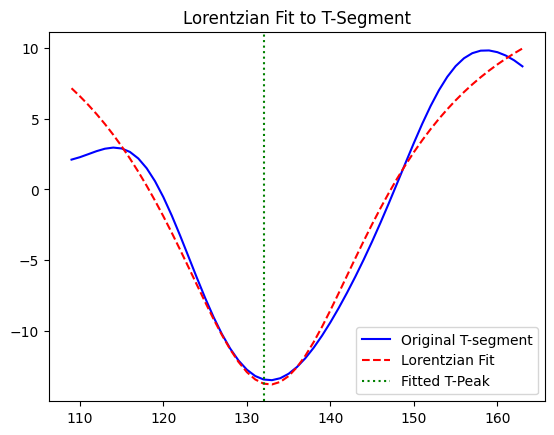

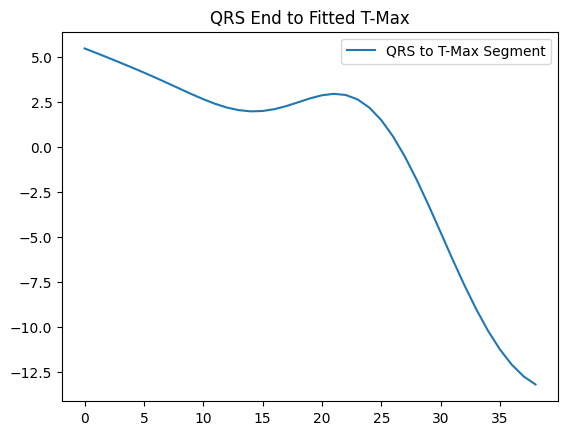

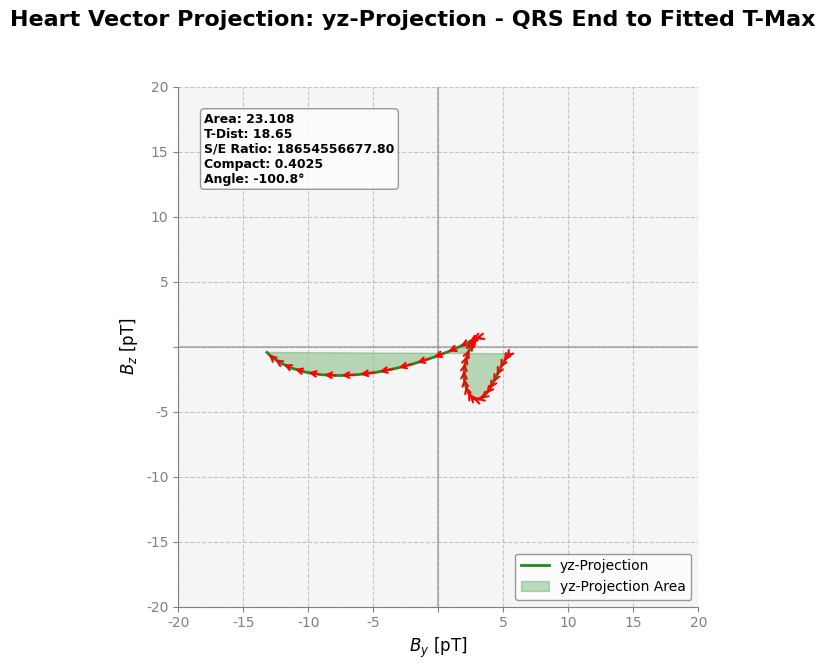

2025-05-03 12:57:24,381 - INFO - Metrics for yz-Projection: Area: 23.108
T-Dist: 18.65
S/E Ratio: 18654556677.80
Compact: 0.4025
Angle: -100.8°


#######################################################################################
#######################################################################################


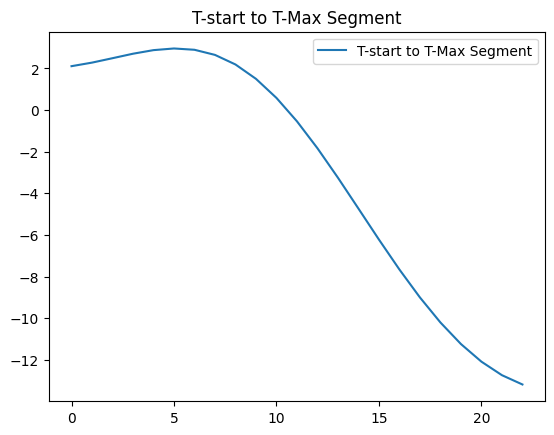

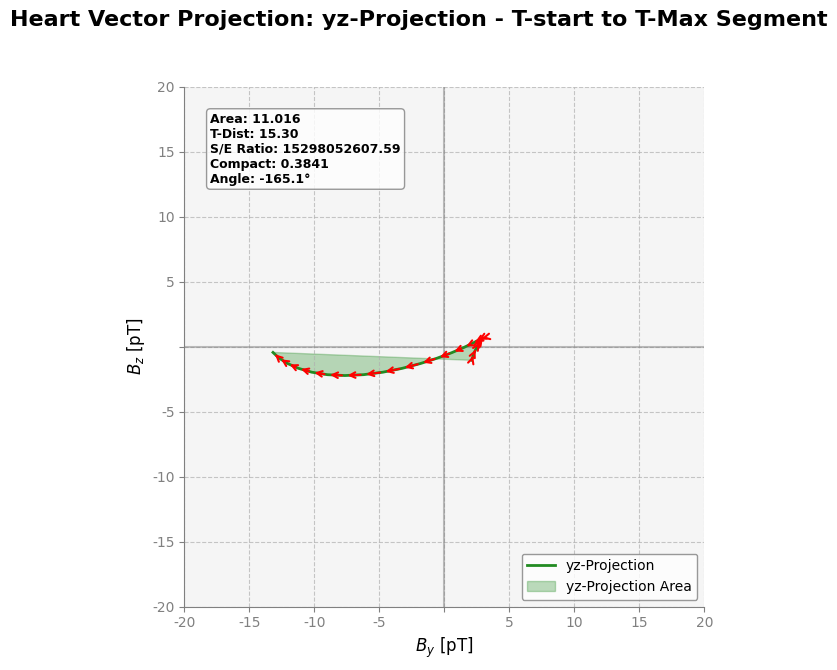

2025-05-03 12:57:24,666 - INFO - Metrics for yz-Projection: Area: 11.016
T-Dist: 15.30
S/E Ratio: 15298052607.59
Compact: 0.3841
Angle: -165.1°


<Axes: xlabel='$B_y$ [pT]', ylabel='$B_z$ [pT]'>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# --- Load data ---
x_data, y_data, z_data = analysis.get_field_directions(avg_channels, key)

analysis.plot4x4(x_data, time_window, f"Original {key}, B_x")
analysis.plot4x4(y_data, time_window, f"Original {key}, B_y")
analysis.plot4x4(z_data, time_window, f"Original {key}, B_z")

# Get field directions
x_data, y_data, z_data = analysis.get_field_directions(avg_channels, key)

f1_data = np.array([y_data[0, 0, :], z_data[0, 0, :]])
print(f"f1_data shape: {f1_data.shape}")

# Find cleanest channel
best_channel, (labels, data, confidence) = analysis.find_cleanest_channel(
    f1_data, resample=False, confidence_weight=0.5, plausibility_weight=0.5
)

analysis.plot_segmented_signal(f1_data[best_channel], labels[best_channel])


print("#######################################################################################")
print("#######################################################################################")

# ----------------------------
# Get T-wave segment
# ----------------------------
mask_t = labels[best_channel] == 3
mask_t[:75] = False  # Ignore everything before index 75!

t_segment = None
if np.any(mask_t):
    t_indices = np.where(mask_t)[0]
    t_start = t_indices[0] + 15
    t_end = t_indices[-1] -15

    t_segment = f1_data[:, t_start:(t_end)]

    plt.figure()
    plt.plot(t_segment[best_channel], label="Best Channel T-Segment")
    plt.legend()
    plt.title("T Segment (t_start > 75)")
    plt.show()

    analysis.plot_heart_vector_projection(t_segment[0], t_segment[1], "yz-Projection", "T Segment (t_start > 75)")

else:
    print("No T-wave segment found!")


print("#######################################################################################")
print("#######################################################################################")


# ----------------------------
# Segment from end of QRS to max of T using Lorentzian fit
# ----------------------------
mask_qrs = labels[best_channel] == 2
mask_qrs[-50:] = False 

if np.any(mask_qrs) and t_segment is not None:
    t_start_qrs = np.where(mask_qrs)[0][0] 
    t_end_qrs = np.where(mask_qrs)[0][-1] 

    # Define search window after QRS
    search_start = t_end_qrs + 15

    # --- Lorentzian Fit ---
    def lorentzian(x, x0, gamma, A, y0):
        return A * gamma**2 / ((x - x0)**2 + gamma**2) + y0

    y_data = t_segment[best_channel]
    x_data = np.arange(len(y_data))

    # Initial guess for Lorentzian parameters
    x0_init = len(y_data) // 2
    gamma_init = 10
    A_init = np.max(y_data) - np.min(y_data)
    y0_init = np.min(y_data)

    try:
        popt, _ = opt.curve_fit(lorentzian, x_data, y_data, p0=[x0_init, gamma_init, A_init, y0_init])
        fitted_center = int(popt[0])
        max_t = t_start + fitted_center  # Absolute index in the full signal

        print(f"QRS start: {t_start_qrs}, QRS end: {t_end_qrs}, Fitted T peak: {max_t}")

        # Plot fitted curve
        y_fit = lorentzian(x_data, *popt)
        plt.figure()
        plt.plot(x_data + t_start, y_data, label="Original T-segment", color='blue')
        plt.plot(x_data + t_start, y_fit, label="Lorentzian Fit", linestyle='--', color='red')
        plt.axvline(max_t, color='green', linestyle=':', label="Fitted T-Peak")
        plt.title("Lorentzian Fit to T-Segment")
        plt.legend()
        plt.show()

        # Segment from QRS end to fitted T peak
        segment_qrs_to_tmax = f1_data[:, t_end_qrs:max_t]

        plt.figure()
        plt.plot(segment_qrs_to_tmax[best_channel], label="QRS to T-Max Segment")
        plt.legend()
        plt.title("QRS End to Fitted T-Max")
        plt.show()

        analysis.plot_heart_vector_projection(segment_qrs_to_tmax[0], segment_qrs_to_tmax[1], "yz-Projection", "QRS End to Fitted T-Max")



    except Exception as e:
        print(f"Lorentzian fit failed: {e}")
else:
    print("QRS segment or T-segment not found!")

# ----------------------------
# Segment from start of T to max of T using Lorentzian fit
# ----------------------------

print("#######################################################################################")
print("#######################################################################################")



segement = t_segment[:, :fitted_center]
plt.figure()
plt.plot(segement[best_channel], label="T-start to T-Max Segment")
plt.legend()
plt.title("T-start to T-Max Segment")
plt.show()
analysis.plot_heart_vector_projection(segement[0], segement[1], "yz-Projection", "T-start to T-Max Segment")

